In [60]:
import numpy as np
import os
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid
import brainsss
import matplotlib
import scipy
import pickle
import sys
import time
# sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants

In [98]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
flies = [116,117,118,120,122,128,129,132,133,134]
#flies = [134]

flies = [str(i) for i in flies]

In [99]:
all_brains = {}
for behavior in ['dRotLabY', 'dRotLabZneg', 'dRotLabZpos']:
    brains = {}
    for fly in flies:
        
        #brainfile = os.path.join(dataset_path, 'fly_' + fly, 'warp', F'corr_{behavior}-applied-meanbrain.nii')
        brainfile = os.path.join(dataset_path, 'fly_' + fly, 'func_0', 'corr', F'20220420_corr_{behavior}_grey.nii')
        try:
            brain = np.asarray(nib.load(brainfile).get_fdata().squeeze(), dtype='float32')
            brains[fly] = brain
            print(F'{fly} success')
        except:
            print(F'{fly} failed')
    #brains[fly] = np.asarray(brains)
    print(f'{behavior} done')
    all_brains[behavior] = brains

116 success
117 success
118 success
120 failed
122 success
128 success
129 success
132 success
133 success
134 success
dRotLabY done
116 success
117 failed
118 success
120 failed
122 success
128 success
129 success
132 success
133 success
134 success
dRotLabZneg done
116 success
117 success
118 success
120 failed
122 success
128 success
129 success
132 success
133 success
134 success
dRotLabZpos done


In [7]:
fixed_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20220301_luke_2_jfrc_affine_zflip_2umiso.nii"#luke.nii"
fixed_resolution = (2,2,2)

fixed = np.asarray(nib.load(fixed_path).get_fdata().squeeze(), dtype='float32')
fixed = ants.from_numpy(fixed)
fixed.set_spacing(fixed_resolution)

In [103]:
all_brains['dRotLabZneg'].shape

AttributeError: 'dict' object has no attribute 'shape'

In [114]:
moving_resolution = (2.611, 2.611, 5)
warped_brains = []
for fly in flies:
    print(fly)
    try:
        moving = all_brains['dRotLabY'][fly]
    except:
        print(F'could not find {fly}')
        continue
    
    moving = ants.from_numpy(moving)
    moving.set_spacing(moving_resolution)
    
    ###########################
    ### Organize Transforms ###
    ###########################
    warp_directory = os.path.join(dataset_path, 'fly_' + fly, 'warp')
    
    warp_sub_dir = 'func-to-anat_fwdtransforms_2umiso'
    affine_file = os.listdir(os.path.join(warp_directory, warp_sub_dir))[0]
    affine_path = os.path.join(warp_directory, warp_sub_dir, affine_file)

    warp_sub_dir = 'anat-to-meanbrain_fwdtransforms_2umiso'
    syn_files = os.listdir(os.path.join(warp_directory, warp_sub_dir))
    syn_linear_path = os.path.join(warp_directory, warp_sub_dir, [x for x in syn_files if '.mat' in x][0])
    syn_nonlinear_path = os.path.join(warp_directory, warp_sub_dir, [x for x in syn_files if '.nii.gz' in x][0])

    transforms = [affine_path, syn_linear_path, syn_nonlinear_path]
    
    ########################
    ### Apply Transforms ###
    ########################
    moco = ants.apply_transforms(fixed, moving, transforms)
    warped_brains.append(moco.numpy())
    

116
117
118
120
could not find 120
122
128
129
132
133
134


In [115]:
warped_brains = np.asarray(warped_brains)

In [106]:
warped_brains.shape

(9, 314, 146, 91)

In [53]:
atlas = brainsss.load_roi_atlas()

In [54]:
explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas)

In [116]:
input_canvas = np.zeros((500,500,3))
data_to_plot = np.mean(np.nan_to_num(warped_brains),axis=0)[:,:,::-1]
vmax = np.max(data_to_plot)

explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                    roi_masks,
                                                    roi_contours,
                                                    data_to_plot,
                                                    input_canvas,
                                                    vmax=vmax,
                                                    cmap='hot')

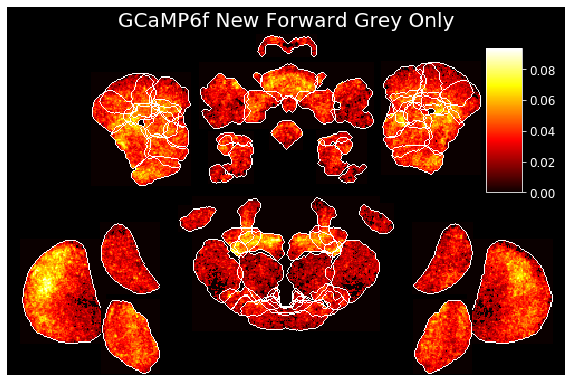

In [117]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(explosion_map[170:,:])
plt.title('GCaMP6f New Forward Grey Only',color='w',y=.93,fontsize=20)
plt.axis('off')

cax = fig.add_axes([0.79, 0.5, 0.05, 0.2])
cmap = matplotlib.cm.hot
norm = matplotlib.colors.Normalize(vmin=0, vmax=vmax)
cb = matplotlib.colorbar.ColorbarBase(ax=cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')

cb.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='white',fontsize=12);
cb.outline.set_edgecolor('white')
#cb.set_label('Some Units')


save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr)
plt.savefig(fname,dpi=300,bbox_inches='tight')

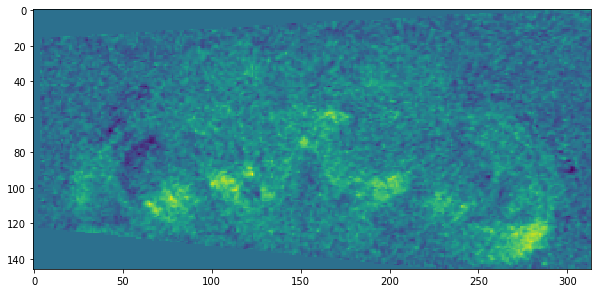

In [102]:
plt.figure(figsize=(10,10))
plt.imshow(data_to_plot[:,:,30].T)

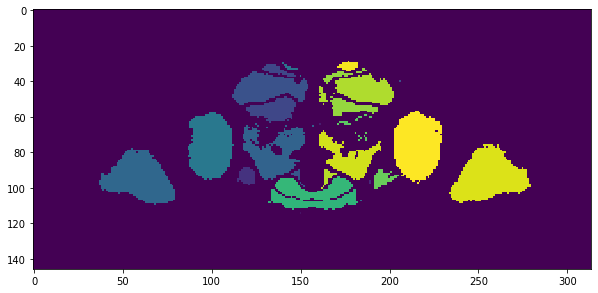

In [101]:
plt.figure(figsize=(10,10))
plt.imshow(atlas[:,:,30].T)